In [ ]:
# ViT Training Script for CXR Classifier

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score

import timm  # ViT models

from transformers import AutoTokenizer
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity

### Impression to Label Classifier - BioClinicalBERT

In [ ]:
# Load metadata
df = pd.read_csv("/content/drive/MyDrive/train/train_metadata_merged.csv")

# Label columns
label_cols = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
               "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
               "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"]

df[label_cols] = df[label_cols].fillna(0).replace(-1, 0).astype(int)

# Keep only required columns for Stage 1
df_stage1 = df[["cleaned_impression"] + label_cols]

In [ ]:
df_stage1["cleaned_impression"].apply(type).value_counts()

,count
cleaned_impression,
<class 'str'>,20583
<class 'float'>,19


In [ ]:
# replace NaNs with blank space
df_stage1["cleaned_impression"] = df_stage1["cleaned_impression"].fillna("")
df_stage1["cleaned_impression"] = df_stage1["cleaned_impression"].astype(str)

<ipython-input-49-e5697f099dd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stage1["cleaned_impression"] = df_stage1["cleaned_impression"].fillna("")
<ipython-input-49-e5697f099dd7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stage1["cleaned_impression"] = df_stage1["cleaned_impression"].astype(str)


In [ ]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def encode(batch):
    encodings = tokenizer(batch["cleaned_impression"],
                          padding="max_length",
                          truncation=True,
                          max_length=256)
    # Make sure labels are floats
    labels = [ [float(batch[col][i]) for col in label_cols] for i in range(len(batch["cleaned_impression"])) ]
    encodings["labels"] = labels
    return encodings

dataset = Dataset.from_pandas(df_stage1)
dataset = dataset.map(encode, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Train-test split
dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
val_ds = dataset["test"]

Map:   0%|          | 0/20602 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Model set up and training
model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=14,
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir="./logs",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (logits > 0).astype(int)  # threshold at 0 for logits
    return {
        "f1": f1_score(labels, preds, average="micro"),
        "precision": precision_score(labels, preds, average="micro"),
        "recall": recall_score(labels, preds, average="micro"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

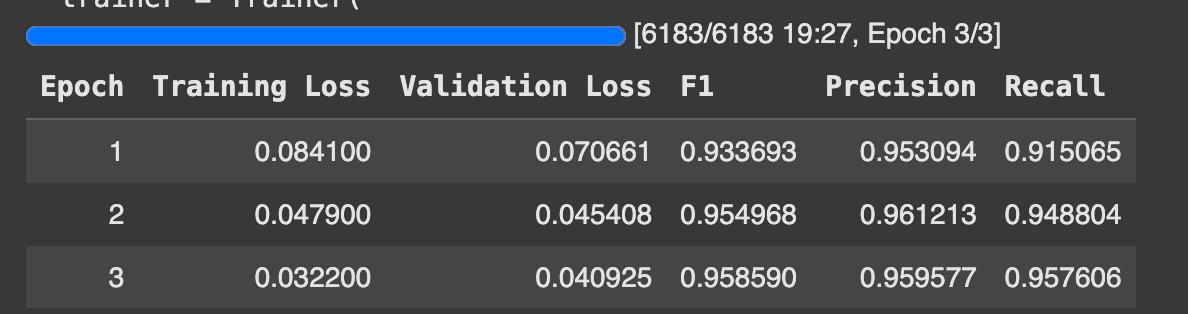

In [ ]:
# Save and load model
model.save_pretrained("/content/drive/MyDrive/impressions_to_label_model")
tokenizer.save_pretrained("/content/drive/MyDrive/vit_model/impressions_to_label_model")

('/content/drive/MyDrive/vit_model/mpressions_to_label_model/tokenizer_config.json',
 '/content/drive/MyDrive/vit_model/mpressions_to_label_model/special_tokens_map.json',
 '/content/drive/MyDrive/vit_model/mpressions_to_label_model/vocab.txt',
 '/content/drive/MyDrive/vit_model/mpressions_to_label_model/added_tokens.json',
 '/content/drive/MyDrive/vit_model/mpressions_to_label_model/tokenizer.json')

In [ ]:
# Predict labels for the entire dataset
def predict_labels(impression_text):
    impression_text = str(impression_text)  # force string conversion
    tokens = tokenizer(impression_text,
                       return_tensors="pt",
                       truncation=True,
                       padding=True,
                       max_length=256).to(model.device)
    with torch.no_grad():
        logits = model(**tokens).logits
    preds = (logits > 0).int().squeeze().tolist()
    return dict(zip(label_cols, preds))

df["predicted_labels"] = df["cleaned_impression"].apply(predict_labels)

# Create one-hot encoded columns from predicted_labels dict
preds_df = pd.json_normalize(df["predicted_labels"])
df_stage1_output = pd.concat([df, preds_df], axis=1)


In [ ]:
# Save the predicted labels as CSV for seamless integration with ViT classifier
df_stage1_output.to_csv("/content/drive/MyDrive/impression_to_labels_predictions.csv", index=False)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/content/drive/MyDrive/impressions_to_label_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(DEVICE)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
label_cols = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
    'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
    'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other',
    'Pneumonia', 'Pneumothorax', 'Support Devices'
]

# If predicted columns have `.1` suffix
pred_cols = [col + '.1' for col in label_cols]

# Force conversion to integer
y_true = df_stage1_output[label_cols].astype(int).values
y_pred = df_stage1_output[pred_cols].astype(int).values

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=label_cols,
    zero_division=0
)

print(report)

                            precision    recall  f1-score   support

               Atelectasis       0.98      0.96      0.97      2201
              Cardiomegaly       0.96      0.95      0.96      2035
             Consolidation       0.98      0.86      0.92      1044
                     Edema       0.98      0.97      0.97      1213
Enlarged Cardiomediastinum       0.92      0.94      0.93      1046
                  Fracture       0.97      0.98      0.98       996
               Lung Lesion       0.95      0.98      0.97      1498
              Lung Opacity       0.98      0.99      0.99      6760
                No Finding       0.97      0.98      0.97      3848
          Pleural Effusion       0.99      0.99      0.99      5669
             Pleural Other       0.98      0.98      0.98       691
                 Pneumonia       0.93      0.90      0.92       832
              Pneumothorax       0.98      0.97      0.97      1250
           Support Devices       0.99      0.99

In [ ]:
import torch.nn.functional as F

def predict_probs(impression_text):
    impression_text = str(impression_text)
    tokens = tokenizer(
        impression_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(model.device)

    with torch.no_grad():
        logits = model(**tokens).logits
        probs = F.sigmoid(logits).squeeze().tolist()  # convert logits to probabilities

    return dict(zip(label_cols, probs))

In [ ]:
df_stage1_output["predicted_probs"] = df_stage1_output["cleaned_impression"].apply(predict_probs)
probs_df = pd.json_normalize(df_stage1_output["predicted_probs"])
probs_df.columns = [col + '_prob' for col in probs_df.columns]  # e.g., 'Atelectasis_prob'

df_stage1_output = pd.concat([df_stage1_output, probs_df], axis=1)

In [ ]:
from sklearn.metrics import roc_auc_score

prob_cols = [col + '_prob' for col in label_cols]
y_probs = df_stage1_output[prob_cols].astype(float).values
y_true = df_stage1_output[label_cols].astype(int).values

# Micro and Macro AUC
auc_micro = roc_auc_score(y_true, y_probs, average='micro')
auc_macro = roc_auc_score(y_true, y_probs, average='macro')

print(f"Micro-Averaged AUC: {auc_micro:.4f}")
print(f"Macro-Averaged AUC: {auc_macro:.4f}")

Micro-Averaged AUC: 0.9965
Macro-Averaged AUC: 0.9941


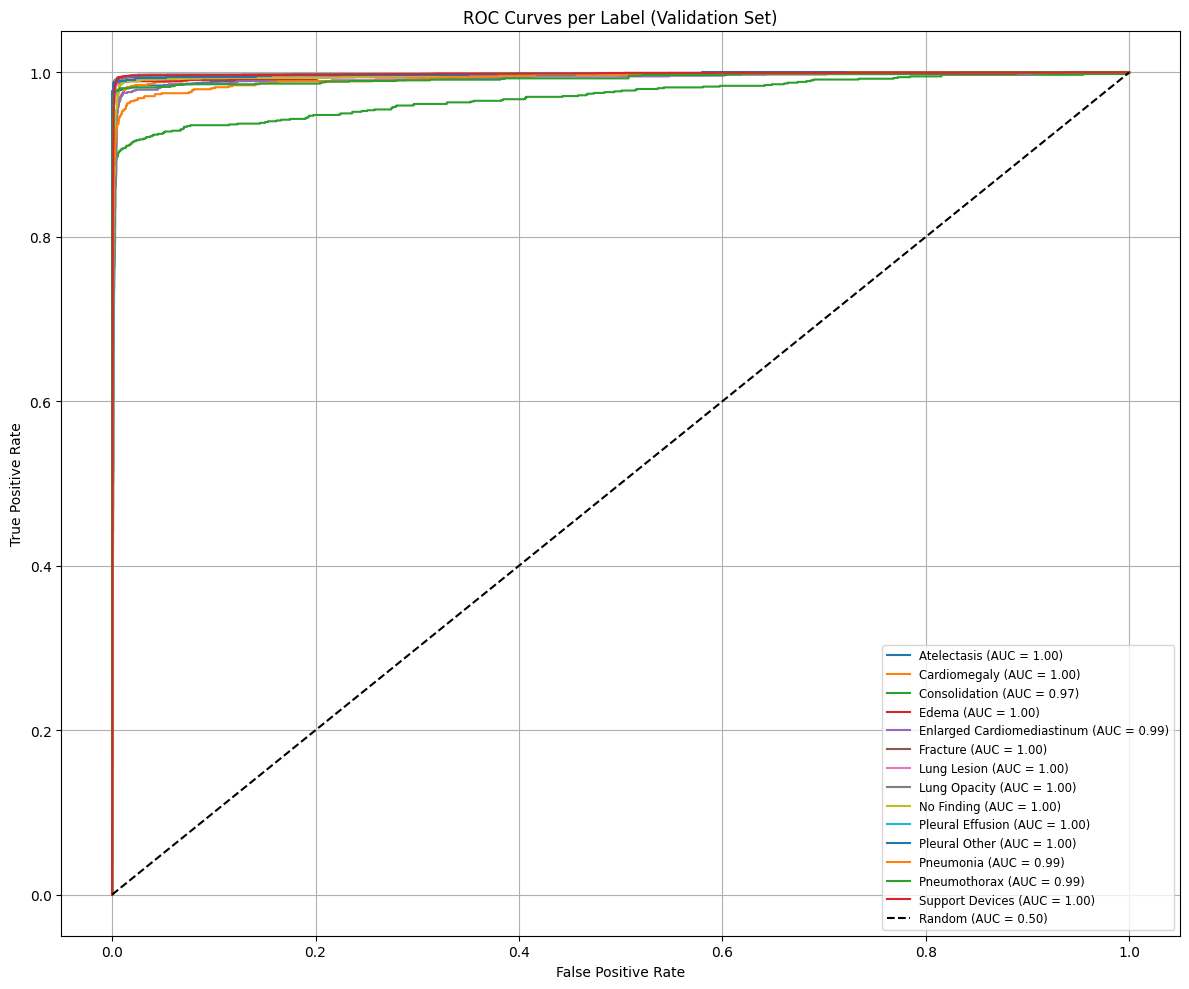

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true: ground truth (binary)
# y_probs: predicted probabilities (floats between 0 and 1)

plt.figure(figsize=(12, 10))

for i, label in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Label (Validation Set)')
plt.legend(loc='lower right', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

per_label_auc = {
    label: roc_auc_score(y_true[:, i], y_probs[:, i])
    for i, label in enumerate(label_cols)
}

import pandas as pd

auc_df = pd.DataFrame.from_dict(per_label_auc, orient='index', columns=['AUC']).sort_values(by='AUC', ascending=False)
display(auc_df)

,AUC
Support Devices,0.998185
Pleural Other,0.997866
Pleural Effusion,0.997796
Fracture,0.997449
Lung Opacity,0.997184
Lung Lesion,0.996153
No Finding,0.996018
Cardiomegaly,0.995891
Edema,0.995691
Atelectasis,0.995520


### ViT

See "ViT classifier_FINAL.ipynb" for ViT model training

### Label to Image Inference

In [ ]:
LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]
NUM_CLASSES = len(LABELS)
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load your test dataset
df_test = pd.read_csv("/content/drive/MyDrive/test/test_metadata_merged.csv")

# Clean and add 'image_path' for test images
df_test["filename"] = df_test["path_to_image"].str.replace("/", "_").str.replace(".jpg", ".png")
df_test["path_to_image"] = "/content/drive/MyDrive/test/images/" + df_test["filename"]

In [ ]:
# Dataset and transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

class CheXpertDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path_to_image']

        # ✅ DEBUG HERE
        print("DEBUG image_path:", image_path)
        print("Type:", type(image_path))

        image = Image.open(str(image_path)).convert("RGB")  # force string

        if self.transform:
            image = self.transform(image)

        labels = row[LABELS].astype(np.float32).values
        return image, torch.tensor(labels)


# Dataset and DataLoader
test_dataset = CheXpertDataset(df_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
# Load the trained ViT model
class ViTClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=NUM_CLASSES, pretrained=False):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTClassifier().to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/vit_weights_only_5.26.pt"))
model.eval()

print("ViT model loaded. Ready for inference!")

ViT model loaded. Ready for inference!


In [ ]:
# Run inference on test images
all_probs, all_preds = [], []

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Inference on test images"):
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

all_probs = np.vstack(all_probs)
all_preds = np.vstack(all_preds)

Inference on test images:   0%|          | 0/276 [00:00<?, ?it/s]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31283_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33150_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27872_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27903_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20560_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13157_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29011_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00989_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   0%|          | 1/276 [00:13<1:03:36, 13.88s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32663_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10414_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02956_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31120_study27_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00359_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18718_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31003_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32978_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   1%|          | 2/276 [00:25<58:37, 12.84s/it]  

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03961_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21710_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30428_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21299_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25192_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04666_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02662_study29_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32307_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   1%|          | 3/276 [00:37<55:30, 12.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20117_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11525_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28685_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15552_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19110_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04344_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08518_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30946_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   1%|▏         | 4/276 [00:49<54:34, 12.04s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04463_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03615_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34059_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09563_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05362_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02428_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01825_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04142_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   2%|▏         | 5/276 [01:01<54:22, 12.04s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29258_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19582_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32400_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04660_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32946_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19726_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00865_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06123_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   2%|▏         | 6/276 [01:13<54:30, 12.11s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25608_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21452_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08788_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32209_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19651_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27190_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08941_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23351_study39_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   3%|▎         | 7/276 [01:25<53:58, 12.04s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10589_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24727_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07112_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24239_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07169_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10613_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34006_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23471_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   3%|▎         | 8/276 [01:37<54:12, 12.14s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31720_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23502_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16419_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26094_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22922_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25620_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09279_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24697_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   3%|▎         | 9/276 [01:48<52:24, 11.78s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13250_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14314_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20940_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09069_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26904_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16814_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01814_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06516_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   4%|▎         | 10/276 [02:00<51:43, 11.67s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34050_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21220_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10334_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19928_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23351_study41_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16079_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22020_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33553_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:   4%|▍         | 11/276 [02:11<50:50, 11.51s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22816_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34297_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24014_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32595_study30_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07784_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01893_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00023_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22058_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   4%|▍         | 12/276 [02:22<50:38, 11.51s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15432_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12821_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32937_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29836_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09962_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30166_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09419_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09756_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   5%|▍         | 13/276 [02:34<51:15, 11.69s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09754_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12676_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16417_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28706_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30632_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10425_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22440_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02194_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   5%|▌         | 14/276 [02:46<50:45, 11.62s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31055_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25914_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09198_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15318_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16841_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19337_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15523_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14172_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   5%|▌         | 15/276 [02:57<50:14, 11.55s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33592_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30547_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03027_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16352_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27526_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07536_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02334_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09211_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   6%|▌         | 16/276 [03:08<49:37, 11.45s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03133_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24509_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15877_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31881_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26096_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32620_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33942_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01857_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   6%|▌         | 17/276 [03:20<49:41, 11.51s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27239_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11575_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15315_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19860_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11577_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04886_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07843_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24041_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   7%|▋         | 18/276 [03:32<49:27, 11.50s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14925_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18849_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14663_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31263_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15293_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01087_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23721_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27264_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   7%|▋         | 19/276 [03:43<49:17, 11.51s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32161_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15358_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14604_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04454_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11183_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09340_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21917_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33900_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   7%|▋         | 20/276 [03:54<48:24, 11.35s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04706_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28942_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07835_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31378_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04338_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24012_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06602_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01386_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   8%|▊         | 21/276 [04:06<48:45, 11.47s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18602_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32460_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08963_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08013_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00952_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23675_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28549_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11002_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   8%|▊         | 22/276 [04:18<49:02, 11.58s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23734_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31130_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02474_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20716_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05037_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11122_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26042_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01233_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:   8%|▊         | 23/276 [04:30<49:12, 11.67s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00455_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21910_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08391_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25190_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08387_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14380_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15954_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05335_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:   9%|▊         | 24/276 [04:41<48:25, 11.53s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15232_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16507_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25989_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12946_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06747_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26272_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05906_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02367_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   9%|▉         | 25/276 [04:53<48:33, 11.61s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09572_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26108_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12628_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31507_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08763_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20578_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00109_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08553_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:   9%|▉         | 26/276 [05:03<47:25, 11.38s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28540_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12656_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10182_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06986_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18347_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28001_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28432_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21675_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  10%|▉         | 27/276 [05:15<47:18, 11.40s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20738_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13573_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01910_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00397_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10240_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07025_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26398_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23428_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  10%|█         | 28/276 [05:26<46:44, 11.31s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31436_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26595_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34295_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00161_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34210_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26244_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16999_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20967_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  11%|█         | 29/276 [05:37<46:30, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10914_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01791_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13671_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21510_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20645_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30903_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24805_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23236_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  11%|█         | 30/276 [05:49<46:35, 11.36s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19648_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07815_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26740_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07632_study34_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07634_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15917_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28746_study45_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01335_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pa

Inference on test images:  11%|█         | 31/276 [06:00<46:01, 11.27s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33112_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27719_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10675_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02081_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06104_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33892_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17616_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24284_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  12%|█▏        | 32/276 [06:11<45:25, 11.17s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30413_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14444_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31377_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13302_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16452_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33397_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05550_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32506_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  12%|█▏        | 33/276 [06:22<45:38, 11.27s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13111_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19774_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00900_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26224_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06524_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04170_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07916_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11529_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  12%|█▏        | 34/276 [06:33<45:22, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15507_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19101_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25226_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19511_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33390_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16095_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03002_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15001_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  13%|█▎        | 35/276 [06:45<45:44, 11.39s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32646_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04875_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10876_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20309_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31684_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33275_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18475_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10884_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  13%|█▎        | 36/276 [06:57<45:39, 11.42s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20712_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25727_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31016_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33291_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06822_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07072_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21585_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26460_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  13%|█▎        | 37/276 [07:08<45:33, 11.44s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24714_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01440_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10211_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17284_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27893_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03235_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28353_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33466_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  14%|█▍        | 38/276 [07:19<45:14, 11.40s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14380_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00195_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29384_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24771_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21656_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27748_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34163_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15157_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  14%|█▍        | 39/276 [07:31<45:19, 11.48s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00208_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03359_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21262_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26693_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19625_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02792_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16893_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00134_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  14%|█▍        | 40/276 [07:43<45:19, 11.52s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06178_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24846_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10970_study37_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11353_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32563_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06007_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30792_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23423_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  15%|█▍        | 41/276 [07:54<44:46, 11.43s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05092_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29958_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05400_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32554_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20196_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25502_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05057_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22515_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  15%|█▌        | 42/276 [08:05<44:30, 11.41s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08469_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00735_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10879_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01925_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12007_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32094_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28704_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00309_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  16%|█▌        | 43/276 [08:17<44:20, 11.42s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21625_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21481_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07573_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01987_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13657_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22456_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04595_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13371_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  16%|█▌        | 44/276 [08:29<44:44, 11.57s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12892_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22495_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03520_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08792_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31070_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17491_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02581_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25769_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  16%|█▋        | 45/276 [08:40<44:43, 11.62s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32884_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33969_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20995_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14981_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04817_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09587_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27168_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11132_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  17%|█▋        | 46/276 [08:51<43:53, 11.45s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31978_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03558_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32615_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26674_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22749_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22476_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07797_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14049_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  17%|█▋        | 47/276 [09:03<43:40, 11.44s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13666_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01382_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31479_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07667_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05192_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06204_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25030_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32317_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  17%|█▋        | 48/276 [09:14<42:50, 11.27s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20209_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31645_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20453_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22658_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24230_study28_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09859_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15799_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33181_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  18%|█▊        | 49/276 [09:25<42:07, 11.13s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33248_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34553_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04385_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04031_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12571_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30206_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03846_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12881_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  18%|█▊        | 50/276 [09:37<42:48, 11.37s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00657_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21926_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16883_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05933_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30812_study31_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23424_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17406_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18245_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  18%|█▊        | 51/276 [09:48<42:59, 11.46s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01821_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24842_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29603_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01565_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33474_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12203_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07953_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29362_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  19%|█▉        | 52/276 [09:59<42:03, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26695_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21257_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19941_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24483_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26812_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03635_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09407_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12247_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  19%|█▉        | 53/276 [10:10<41:57, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19047_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21864_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34371_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15870_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19123_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09739_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29763_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08708_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  20%|█▉        | 54/276 [10:21<41:27, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15582_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17055_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10312_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21519_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05188_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21027_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00743_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10250_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  20%|█▉        | 55/276 [10:33<42:15, 11.47s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27059_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08920_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22907_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30569_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30263_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31751_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06635_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10463_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  20%|██        | 56/276 [10:45<42:27, 11.58s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05295_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34296_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18027_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28371_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19504_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27257_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25854_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14959_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  21%|██        | 57/276 [10:56<41:37, 11.40s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13330_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28035_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14842_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17477_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28494_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19297_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02491_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19988_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  21%|██        | 58/276 [11:08<41:49, 11.51s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25156_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31912_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27999_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28014_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26150_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07532_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20291_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26637_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  21%|██▏       | 59/276 [11:19<41:22, 11.44s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07632_study32_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10211_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03440_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01838_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01070_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28533_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01341_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30454_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  22%|██▏       | 60/276 [11:30<40:38, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17642_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23552_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02017_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10749_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11532_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24732_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33129_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22930_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  22%|██▏       | 61/276 [11:42<40:37, 11.34s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24022_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04889_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24992_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10913_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30694_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19983_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27088_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34410_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  22%|██▏       | 62/276 [11:53<40:13, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11632_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01158_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20877_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00493_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29533_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02601_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30891_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13590_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  23%|██▎       | 63/276 [12:04<40:19, 11.36s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25580_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06209_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27856_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01412_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07044_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11413_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03819_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27747_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  23%|██▎       | 64/276 [12:16<40:25, 11.44s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14585_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26594_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00486_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11307_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23997_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19919_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11721_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30957_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  24%|██▎       | 65/276 [12:28<40:31, 11.53s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17834_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21585_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03122_study22_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01155_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28011_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27908_study3_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17471_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33340_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  24%|██▍       | 66/276 [12:40<41:06, 11.75s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06949_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05540_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00589_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28134_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32339_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13678_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30028_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03756_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pa

Inference on test images:  24%|██▍       | 67/276 [12:51<39:37, 11.38s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30946_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09259_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12810_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32837_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10634_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24830_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17124_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19029_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  25%|██▍       | 68/276 [13:02<39:19, 11.34s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26742_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13714_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27947_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12881_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28799_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09799_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00896_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07488_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  25%|██▌       | 69/276 [13:14<39:39, 11.50s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14445_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32292_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16089_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13593_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15467_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22875_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12542_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14760_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  25%|██▌       | 70/276 [13:25<39:24, 11.48s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18823_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07945_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11129_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17726_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26124_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26618_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08982_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04895_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  26%|██▌       | 71/276 [13:36<38:58, 11.41s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07383_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14811_study12_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19689_study61_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26324_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08752_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06490_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30104_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29362_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  26%|██▌       | 72/276 [13:48<38:51, 11.43s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18476_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32286_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31910_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03669_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00661_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12017_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30537_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21875_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  26%|██▋       | 73/276 [13:59<38:17, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23028_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03937_study3_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06581_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10090_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05994_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21718_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16551_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29104_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  27%|██▋       | 74/276 [14:10<37:40, 11.19s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21724_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17149_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16417_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29942_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02992_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27215_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11500_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17161_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  27%|██▋       | 75/276 [14:21<37:12, 11.11s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09639_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10478_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18823_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18470_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16268_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20488_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21481_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02283_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  28%|██▊       | 76/276 [14:32<37:07, 11.14s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02367_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22354_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11991_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29327_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20433_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28713_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15145_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27384_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  28%|██▊       | 77/276 [14:46<39:51, 12.02s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01099_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33453_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30848_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11270_study22_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05410_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03532_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33021_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02688_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pa

Inference on test images:  28%|██▊       | 78/276 [14:58<39:13, 11.89s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05564_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08870_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21066_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10485_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09191_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15162_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33269_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26522_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  29%|██▊       | 79/276 [15:09<38:42, 11.79s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22737_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17967_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24901_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21653_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06857_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04510_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24041_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30578_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  29%|██▉       | 80/276 [15:22<39:19, 12.04s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10766_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09255_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26613_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20959_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08896_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30909_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06590_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16307_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  29%|██▉       | 81/276 [15:33<38:07, 11.73s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30154_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22553_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22655_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00146_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32369_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13107_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18132_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17602_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  30%|██▉       | 82/276 [15:44<37:30, 11.60s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12432_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05164_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18086_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04836_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06771_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23506_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33190_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21567_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  30%|███       | 83/276 [15:55<37:01, 11.51s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17258_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15828_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08963_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19278_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18078_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11185_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22826_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06338_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  30%|███       | 84/276 [16:06<36:25, 11.38s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15838_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13677_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06847_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24002_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19210_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33552_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13175_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17350_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  31%|███       | 85/276 [16:17<35:47, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33794_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20566_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16877_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31068_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22164_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27786_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23984_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32873_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  31%|███       | 86/276 [16:28<35:18, 11.15s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29018_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17625_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17869_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10282_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26525_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29850_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16981_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04852_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  32%|███▏      | 87/276 [16:40<36:08, 11.47s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28416_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19775_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23521_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11970_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11515_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21069_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14512_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11786_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  32%|███▏      | 88/276 [16:53<36:44, 11.73s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00385_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01832_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29820_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02732_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15450_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24981_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25734_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00740_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  32%|███▏      | 89/276 [17:04<35:45, 11.47s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05366_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32468_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15276_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07054_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20317_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14487_study30_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30337_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27438_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  33%|███▎      | 90/276 [17:15<35:35, 11.48s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19949_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02743_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05202_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26081_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31549_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33252_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29708_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17582_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  33%|███▎      | 91/276 [17:26<34:55, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16781_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05456_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11583_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22083_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12763_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09790_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27680_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28661_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  33%|███▎      | 92/276 [17:38<34:51, 11.37s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32752_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02368_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20157_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22079_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24242_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07632_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14009_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12667_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  34%|███▎      | 93/276 [17:49<34:33, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22734_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14888_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21622_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05286_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11259_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01005_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29710_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17448_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  34%|███▍      | 94/276 [18:00<34:07, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16686_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23902_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05730_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24163_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17536_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14971_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28477_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31341_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  34%|███▍      | 95/276 [18:11<33:37, 11.14s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13381_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30554_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06010_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25661_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07222_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03972_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15989_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13649_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  35%|███▍      | 96/276 [18:22<33:41, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19113_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15907_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30192_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20650_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12447_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08805_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32503_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08853_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  35%|███▌      | 97/276 [18:33<33:21, 11.18s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04558_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02750_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07659_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29634_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10367_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24829_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04814_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09071_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  36%|███▌      | 98/276 [18:45<33:56, 11.44s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25911_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33383_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14983_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25085_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05094_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28547_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08093_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17712_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  36%|███▌      | 99/276 [18:57<34:08, 11.57s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01448_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18114_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05875_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06538_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23369_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32662_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06665_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32559_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  36%|███▌      | 100/276 [19:08<33:31, 11.43s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20097_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07837_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07906_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27352_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18647_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21565_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20880_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32188_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  37%|███▋      | 101/276 [19:20<33:28, 11.48s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03778_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12309_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17845_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20532_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16833_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03362_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07815_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15964_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  37%|███▋      | 102/276 [19:32<33:53, 11.68s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07474_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27360_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19058_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26339_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33319_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27549_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05293_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15058_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  37%|███▋      | 103/276 [19:43<33:27, 11.61s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21471_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10307_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17886_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25054_study8_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26167_study3_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04258_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33708_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20124_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  38%|███▊      | 104/276 [19:55<32:50, 11.45s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14889_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14344_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09531_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33674_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34568_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12698_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01086_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16580_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  38%|███▊      | 105/276 [20:06<32:16, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27903_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19358_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05349_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31006_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09028_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29504_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14096_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11213_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  38%|███▊      | 106/276 [20:17<31:58, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22574_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30353_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27676_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27078_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07778_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32284_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15275_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08301_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  39%|███▉      | 107/276 [20:28<31:21, 11.14s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18406_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27912_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27821_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/valid_patient64625_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13852_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08890_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26612_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01553_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  39%|███▉      | 108/276 [20:38<30:58, 11.06s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04650_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11778_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20986_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04742_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02563_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15195_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04113_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24299_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  39%|███▉      | 109/276 [20:50<30:46, 11.06s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23100_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32226_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31289_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04643_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02208_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04207_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25638_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33671_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  40%|███▉      | 110/276 [21:01<30:38, 11.07s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32913_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15697_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23823_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11075_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15326_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34345_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02409_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05073_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  40%|████      | 111/276 [21:12<30:30, 11.10s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02207_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32313_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27549_study22_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08905_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00948_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10467_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12843_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23054_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  41%|████      | 112/276 [21:23<30:32, 11.17s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08274_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23824_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20755_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23838_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03389_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21286_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03876_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32198_study15_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  41%|████      | 113/276 [21:35<30:38, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26997_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30498_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29169_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13431_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30396_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12282_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28054_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22701_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  41%|████▏     | 114/276 [21:46<30:35, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25677_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33306_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26732_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27680_study25_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05094_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01312_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30070_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23495_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  42%|████▏     | 115/276 [21:57<29:59, 11.18s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24326_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18089_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16936_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32479_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20070_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19196_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34256_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23695_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  42%|████▏     | 116/276 [22:08<29:52, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21911_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25966_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient60658_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32638_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09872_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11274_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09269_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03150_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  42%|████▏     | 117/276 [22:19<29:34, 11.16s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22673_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25994_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09033_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31304_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22374_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13685_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04329_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30229_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  43%|████▎     | 118/276 [22:32<30:42, 11.66s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24541_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10624_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01232_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30713_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18533_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32734_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01409_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14177_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  43%|████▎     | 119/276 [22:43<29:35, 11.31s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19483_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29934_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22955_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21622_study22_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01203_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28276_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31645_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04527_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  43%|████▎     | 120/276 [22:54<29:19, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34198_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16067_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30790_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06436_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17262_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32973_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13069_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12660_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  44%|████▍     | 121/276 [23:05<29:05, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31126_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12775_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28896_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27628_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29868_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34295_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22110_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26973_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  44%|████▍     | 122/276 [23:17<29:10, 11.37s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14871_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10656_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11576_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31339_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25322_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08262_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34474_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17519_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  45%|████▍     | 123/276 [23:28<28:55, 11.34s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19118_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33656_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02644_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30402_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25441_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31094_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10880_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10542_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  45%|████▍     | 124/276 [23:39<28:38, 11.31s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13270_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13102_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32061_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18240_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23620_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33592_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15420_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31180_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  45%|████▌     | 125/276 [23:51<28:40, 11.39s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13306_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30350_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12932_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06402_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06857_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21131_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01147_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04248_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  46%|████▌     | 126/276 [24:02<28:15, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01452_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11758_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15481_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18635_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22777_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22174_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34452_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00013_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  46%|████▌     | 127/276 [24:13<27:55, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13145_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19756_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16124_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17415_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11710_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33229_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04197_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01853_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  46%|████▋     | 128/276 [24:24<27:46, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19336_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01663_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32286_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23686_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06974_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03803_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08481_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32808_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  47%|████▋     | 129/276 [24:35<27:32, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23158_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14325_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25604_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06604_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19159_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14701_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06469_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12578_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  47%|████▋     | 130/276 [24:46<27:11, 11.17s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16933_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03043_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15455_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27052_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34425_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10381_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03822_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32750_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  47%|████▋     | 131/276 [24:58<27:20, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31027_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02178_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06842_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18097_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09273_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30393_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10173_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23771_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  48%|████▊     | 132/276 [25:09<27:10, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31414_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20012_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07993_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12126_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01425_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22234_study3_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32239_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15285_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  48%|████▊     | 133/276 [25:21<26:50, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22477_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25951_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17892_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05831_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07173_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29072_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17546_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05219_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  49%|████▊     | 134/276 [25:32<26:38, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12779_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18698_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26121_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22086_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11299_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23362_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29544_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08795_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  49%|████▉     | 135/276 [25:43<26:39, 11.35s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12181_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19303_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15400_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16274_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16335_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24005_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03354_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30899_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  49%|████▉     | 136/276 [25:55<26:24, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12630_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30818_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14395_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07742_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32686_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06155_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13492_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07913_study43_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  50%|████▉     | 137/276 [26:06<26:16, 11.34s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03179_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14047_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20198_study37_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16394_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10662_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32770_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02565_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15408_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  50%|█████     | 138/276 [26:17<25:48, 11.22s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05240_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02754_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19669_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23338_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20171_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20497_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06353_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13202_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  50%|█████     | 139/276 [26:28<25:16, 11.07s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30504_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07600_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06866_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09674_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26952_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26806_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11929_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24763_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  51%|█████     | 140/276 [26:39<25:07, 11.08s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07919_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25695_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24678_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00864_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10202_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22211_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25724_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10551_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  51%|█████     | 141/276 [26:50<25:11, 11.19s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28379_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28849_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11754_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27739_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26861_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27864_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03672_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01407_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  51%|█████▏    | 142/276 [27:02<25:14, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05705_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26925_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15861_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25323_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03879_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32476_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11230_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22011_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  52%|█████▏    | 143/276 [27:13<25:09, 11.35s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25574_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33909_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10731_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06760_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31044_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00679_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11443_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14646_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  52%|█████▏    | 144/276 [27:25<25:07, 11.42s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07571_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04684_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06516_study26_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11077_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33732_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00210_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11679_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15965_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  53%|█████▎    | 145/276 [27:36<24:46, 11.35s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27191_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10629_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27465_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20824_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26703_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25063_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30995_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20539_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  53%|█████▎    | 146/276 [27:48<25:02, 11.56s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07737_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient41739_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30142_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14814_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07909_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19635_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01448_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17453_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  53%|█████▎    | 147/276 [28:00<24:53, 11.58s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04822_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13733_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21687_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06149_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21561_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31198_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11818_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20998_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  54%|█████▎    | 148/276 [28:12<25:05, 11.76s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25111_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21371_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06989_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18029_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33890_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08079_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17191_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13194_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  54%|█████▍    | 149/276 [28:23<24:49, 11.73s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21703_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20691_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32162_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33129_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15006_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03335_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02396_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31144_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  54%|█████▍    | 150/276 [28:34<23:57, 11.41s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32209_study3_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22341_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16218_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07106_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17193_study22_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25055_study30_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13708_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13829_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pa

Inference on test images:  55%|█████▍    | 151/276 [28:45<23:20, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15813_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14960_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23572_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17801_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22759_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22823_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29224_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04853_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  55%|█████▌    | 152/276 [28:56<23:08, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19777_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34133_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34185_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33765_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13338_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32658_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16605_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19816_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  55%|█████▌    | 153/276 [29:07<23:05, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07542_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32886_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09949_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30231_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31304_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09193_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03067_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12036_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  56%|█████▌    | 154/276 [29:19<22:45, 11.19s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28374_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18696_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00100_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05954_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12991_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05349_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15910_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16299_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  56%|█████▌    | 155/276 [29:30<22:40, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18865_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22825_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20105_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11349_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12946_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29750_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13667_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06940_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  57%|█████▋    | 156/276 [29:41<22:41, 11.35s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23109_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23846_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16801_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17841_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25701_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33469_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01639_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32239_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  57%|█████▋    | 157/276 [29:53<22:24, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31946_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18226_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26287_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13745_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33387_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31887_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16487_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21103_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  57%|█████▋    | 158/276 [30:04<22:15, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04717_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01201_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33670_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12869_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32139_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14246_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16520_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26139_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  58%|█████▊    | 159/276 [30:15<21:57, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12798_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16628_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03048_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02281_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15625_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28125_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07913_study45_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08950_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  58%|█████▊    | 160/276 [30:26<21:43, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11664_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01580_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11331_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31351_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19725_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29830_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18614_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14791_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  58%|█████▊    | 161/276 [30:38<21:38, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03883_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08276_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15248_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13524_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12197_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17291_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05927_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28771_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  59%|█████▊    | 162/276 [30:49<21:17, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30672_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24618_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27685_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22857_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28453_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17425_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00624_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01744_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  59%|█████▉    | 163/276 [31:00<21:15, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16254_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15066_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25549_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09788_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11985_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15159_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33251_study22_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28166_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  59%|█████▉    | 164/276 [31:11<20:50, 11.16s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33934_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13882_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23207_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27549_study25_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21180_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12073_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11536_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19277_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  60%|█████▉    | 165/276 [31:23<21:02, 11.37s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28078_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13325_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32017_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07697_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29209_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08562_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01329_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34255_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  60%|██████    | 166/276 [31:34<20:49, 11.36s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19693_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20983_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27278_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00844_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24031_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02631_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07593_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01263_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  61%|██████    | 167/276 [31:47<21:26, 11.80s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29322_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11193_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03955_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18043_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05070_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17192_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33301_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20028_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  61%|██████    | 168/276 [31:58<20:58, 11.65s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27422_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20047_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10226_study3_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20703_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21792_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15186_study13_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31977_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19865_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  61%|██████    | 169/276 [32:10<20:30, 11.50s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10182_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00534_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03538_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12710_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34324_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34345_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08241_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04859_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  62%|██████▏   | 170/276 [32:21<20:13, 11.45s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13162_study53_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29353_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15514_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01461_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23803_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17045_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18517_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15689_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  62%|██████▏   | 171/276 [32:32<19:53, 11.36s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30782_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18103_study14_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26633_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21585_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33550_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03598_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07651_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14859_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  62%|██████▏   | 172/276 [32:44<19:43, 11.38s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02191_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08505_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00314_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15841_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04857_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08245_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16210_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00397_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  63%|██████▎   | 173/276 [32:55<19:27, 11.34s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27148_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24872_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17719_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26045_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23445_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11132_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06457_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24288_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  63%|██████▎   | 174/276 [33:06<19:15, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12175_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14562_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04729_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17868_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19204_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26886_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27760_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07363_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  63%|██████▎   | 175/276 [33:17<18:57, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12020_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00027_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31922_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02856_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16087_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14286_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33356_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04777_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  64%|██████▍   | 176/276 [33:28<18:43, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27384_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04271_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21373_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06006_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16067_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29439_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24852_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09132_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  64%|██████▍   | 177/276 [33:40<18:31, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09861_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17678_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33863_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03708_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05203_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33516_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06060_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31347_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  64%|██████▍   | 178/276 [33:51<18:17, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19567_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18470_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23847_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15574_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01215_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01146_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13940_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23745_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  65%|██████▍   | 179/276 [34:02<18:01, 11.15s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09316_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08142_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09108_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14414_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28114_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09828_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32864_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33790_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  65%|██████▌   | 180/276 [34:13<17:59, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33616_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24466_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27357_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06516_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34085_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04836_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19356_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00713_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  66%|██████▌   | 181/276 [34:25<17:55, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24206_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17962_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25025_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05567_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23251_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16626_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07207_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21065_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  66%|██████▌   | 182/276 [34:36<17:49, 11.37s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33961_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11891_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06413_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28546_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20068_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00551_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09741_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05923_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  66%|██████▋   | 183/276 [34:47<17:33, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21890_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11166_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27445_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30127_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14485_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18576_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06058_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10932_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  67%|██████▋   | 184/276 [34:58<17:15, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16401_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28729_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14035_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27074_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05625_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26058_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07625_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28038_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  67%|██████▋   | 185/276 [35:10<17:02, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28803_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23317_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30615_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13219_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22446_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10858_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09954_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08943_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  67%|██████▋   | 186/276 [35:21<16:48, 11.21s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11526_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26692_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34101_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12586_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04266_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31472_study27_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29430_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10690_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  68%|██████▊   | 187/276 [35:32<16:34, 11.18s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22327_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28550_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14713_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15574_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00281_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04548_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13017_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17307_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  68%|██████▊   | 188/276 [35:43<16:28, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32003_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23616_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07793_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29291_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06673_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26450_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06008_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24000_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  68%|██████▊   | 189/276 [35:54<16:04, 11.08s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25595_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03290_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26501_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30809_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25213_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27963_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19405_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23213_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  69%|██████▉   | 190/276 [36:05<15:51, 11.06s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31227_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27918_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17566_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06738_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11470_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23475_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00537_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29422_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  69%|██████▉   | 191/276 [36:16<15:36, 11.02s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10147_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09167_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00812_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06201_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13857_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10970_study45_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06403_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27861_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  70%|██████▉   | 192/276 [36:27<15:27, 11.04s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22908_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12092_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11050_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20920_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09364_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12661_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08141_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00259_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  70%|██████▉   | 193/276 [36:38<15:14, 11.01s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05849_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22306_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15353_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06677_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06369_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31137_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16870_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24043_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  70%|███████   | 194/276 [36:49<15:08, 11.07s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08354_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34042_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19616_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30437_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08747_study9_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09330_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21200_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09763_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  71%|███████   | 195/276 [37:01<15:16, 11.31s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33921_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09535_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30318_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15730_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01486_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24532_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30531_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07448_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  71%|███████   | 196/276 [37:12<15:03, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24820_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07408_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26291_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28246_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01221_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30634_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10970_study46_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14380_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  71%|███████▏  | 197/276 [37:23<14:37, 11.10s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19209_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32259_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28056_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34546_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10904_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20385_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33550_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04649_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  72%|███████▏  | 198/276 [37:34<14:18, 11.01s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03478_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00840_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00178_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24528_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14985_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10772_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32214_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28304_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  72%|███████▏  | 199/276 [37:45<14:19, 11.16s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02997_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13066_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27953_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33295_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34178_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19961_study45_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21665_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19407_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  72%|███████▏  | 200/276 [37:57<14:19, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20185_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01069_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31535_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24252_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01893_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34562_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28729_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17810_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  73%|███████▎  | 201/276 [38:08<14:08, 11.31s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13104_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25163_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04599_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33665_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16173_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19029_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04481_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07203_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  73%|███████▎  | 202/276 [38:19<13:52, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10353_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10878_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22971_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32872_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15417_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30668_study8_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17796_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07822_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  74%|███████▎  | 203/276 [38:30<13:38, 11.21s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32488_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17349_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05008_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16719_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11152_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15077_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24016_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23979_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  74%|███████▍  | 204/276 [38:43<13:52, 11.57s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23744_study28_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32198_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29488_study4_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20148_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00769_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20518_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32135_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29848_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pa

Inference on test images:  74%|███████▍  | 205/276 [38:55<13:44, 11.61s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18911_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15017_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16705_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22693_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29263_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07915_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30907_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26049_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  75%|███████▍  | 206/276 [39:05<13:13, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30946_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09354_study20_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02844_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04915_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23829_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01772_study18_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09180_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08081_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  75%|███████▌  | 207/276 [39:16<12:57, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29575_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29959_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26173_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17896_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17483_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13055_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30248_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18586_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  75%|███████▌  | 208/276 [39:28<12:50, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14083_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11383_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26104_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34261_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20014_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24941_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29936_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25906_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  76%|███████▌  | 209/276 [39:39<12:30, 11.21s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22650_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31409_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07872_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06050_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19551_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09778_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11122_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13456_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  76%|███████▌  | 210/276 [39:50<12:24, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33073_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29851_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10823_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25064_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13592_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26948_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33085_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17559_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  76%|███████▋  | 211/276 [40:02<12:16, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15116_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20452_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27868_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00516_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18496_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00012_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08450_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04037_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  77%|███████▋  | 212/276 [40:13<11:58, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14592_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17207_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28880_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26294_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21832_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33977_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12431_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02646_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  77%|███████▋  | 213/276 [40:24<11:43, 11.16s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01278_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07616_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32981_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28958_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10856_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32056_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00321_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33590_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  78%|███████▊  | 214/276 [40:35<11:38, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18183_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19908_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16299_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27387_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29024_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22478_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05052_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17760_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  78%|███████▊  | 215/276 [40:46<11:23, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17267_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11616_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04560_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09530_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14785_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02251_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23250_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11279_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pa

Inference on test images:  78%|███████▊  | 216/276 [40:59<11:32, 11.54s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21483_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31486_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28273_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22185_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02232_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28681_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05938_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28957_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  79%|███████▊  | 217/276 [41:09<11:06, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05995_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11403_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17138_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15386_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34535_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13618_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07556_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13500_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  79%|███████▉  | 218/276 [41:20<10:48, 11.19s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33582_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03421_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05056_study15_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00494_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03122_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14844_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14325_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12454_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  79%|███████▉  | 219/276 [41:31<10:37, 11.18s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20171_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21063_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15505_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18271_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23427_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16166_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19490_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22787_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  80%|███████▉  | 220/276 [41:43<10:40, 11.44s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08285_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15819_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30449_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19976_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23700_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25560_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32867_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10924_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  80%|████████  | 221/276 [41:54<10:23, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02566_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26377_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31521_study18_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12151_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16790_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22459_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01322_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16511_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  80%|████████  | 222/276 [42:05<10:04, 11.19s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19653_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03095_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27331_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18814_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09599_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18562_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19541_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11395_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  81%|████████  | 223/276 [42:17<09:57, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23132_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14735_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33710_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25354_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13855_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25828_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13033_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02321_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  81%|████████  | 224/276 [42:28<09:44, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27066_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18680_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14436_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08318_study21_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24026_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19402_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07587_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31882_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  82%|████████▏ | 225/276 [42:39<09:31, 11.21s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20113_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07637_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15021_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27513_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03271_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13488_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32684_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19307_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  82%|████████▏ | 226/276 [42:50<09:20, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34440_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34028_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32873_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15203_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06516_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12652_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31164_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19905_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  82%|████████▏ | 227/276 [43:02<09:12, 11.28s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04014_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12693_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24958_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17342_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01134_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11886_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21768_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22656_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  83%|████████▎ | 228/276 [43:13<08:57, 11.21s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31700_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10978_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17917_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34070_study27_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22567_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06819_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06945_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02876_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  83%|████████▎ | 229/276 [43:24<08:47, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08385_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12234_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30460_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08287_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02963_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32595_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26332_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19755_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  83%|████████▎ | 230/276 [43:36<08:39, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16112_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28609_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20689_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05936_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04613_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29236_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22416_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01646_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  84%|████████▎ | 231/276 [43:47<08:28, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17185_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24402_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09888_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22398_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22737_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20199_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27772_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12671_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  84%|████████▍ | 232/276 [43:57<08:07, 11.09s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09188_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25279_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20549_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13367_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12648_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26653_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23786_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07570_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  84%|████████▍ | 233/276 [44:09<08:00, 11.17s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17168_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12568_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17655_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10069_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22188_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07529_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20028_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28982_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  85%|████████▍ | 234/276 [44:20<07:49, 11.19s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27216_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07190_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23805_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03074_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27209_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25683_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29750_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00463_study14_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  85%|████████▌ | 235/276 [44:31<07:40, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32871_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03907_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01161_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06165_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04735_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18925_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13513_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24277_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  86%|████████▌ | 236/276 [44:42<07:28, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19377_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23071_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20399_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29455_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23076_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05068_study32_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02382_study30_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14045_study27_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_p

Inference on test images:  86%|████████▌ | 237/276 [44:54<07:20, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13274_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11710_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03527_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20863_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04059_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16970_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19392_study21_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27110_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  86%|████████▌ | 238/276 [45:05<07:07, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29210_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11137_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01806_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02878_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08861_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05076_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12401_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24362_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  87%|████████▋ | 239/276 [45:18<07:15, 11.77s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06495_study5_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28934_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13725_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11514_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00090_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26025_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13876_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13269_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  87%|████████▋ | 240/276 [45:29<06:57, 11.59s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19546_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03626_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31524_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03805_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04434_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14342_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21441_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14714_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  87%|████████▋ | 241/276 [45:41<06:44, 11.56s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18096_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18160_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16721_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19644_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06359_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13887_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12893_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06335_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  88%|████████▊ | 242/276 [45:52<06:31, 11.50s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32676_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29204_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07301_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21881_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11023_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20444_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28986_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06952_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  88%|████████▊ | 243/276 [46:03<06:16, 11.42s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28967_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04596_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18126_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33908_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00375_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29300_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25258_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12064_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  88%|████████▊ | 244/276 [46:15<06:07, 11.48s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14007_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19808_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13764_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06844_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16926_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34240_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07060_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12664_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  89%|████████▉ | 245/276 [46:26<05:50, 11.31s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14297_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03187_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32198_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18013_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14465_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10938_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03122_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08424_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  89%|████████▉ | 246/276 [46:37<05:37, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09692_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30166_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28164_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17370_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07933_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03952_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11585_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29488_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  89%|████████▉ | 247/276 [46:48<05:26, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25243_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23179_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08697_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18899_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30001_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34399_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03631_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02817_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  90%|████████▉ | 248/276 [47:00<05:16, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14080_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31034_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29956_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30799_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03793_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26505_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32068_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25184_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  90%|█████████ | 249/276 [47:11<05:05, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17324_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02360_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28158_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07651_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24808_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24790_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19592_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25746_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  91%|█████████ | 250/276 [47:22<04:52, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15376_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20325_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01063_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15161_study11_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13552_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29681_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33690_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13331_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  91%|█████████ | 251/276 [47:33<04:40, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15018_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29732_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33177_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33895_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10730_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31879_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23331_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21983_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  91%|█████████▏| 252/276 [47:46<04:36, 11.54s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15622_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30656_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21011_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06812_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25887_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09891_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12731_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22316_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  92%|█████████▏| 253/276 [47:57<04:21, 11.38s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15522_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24008_study19_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11635_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18029_study9_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24848_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26745_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06389_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22198_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  92%|█████████▏| 254/276 [48:08<04:08, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04964_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10900_study35_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24172_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11877_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32371_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23992_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02757_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16836_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  92%|█████████▏| 255/276 [48:19<03:57, 11.30s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07699_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00649_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25540_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13432_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27766_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34374_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16481_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07709_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  93%|█████████▎| 256/276 [48:30<03:45, 11.26s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14861_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11214_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03725_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34587_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05455_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07953_study10_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08332_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12706_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  93%|█████████▎| 257/276 [48:42<03:35, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24174_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29732_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30864_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02669_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10283_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05346_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29158_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10487_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  93%|█████████▎| 258/276 [48:53<03:22, 11.23s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11239_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23244_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21597_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00724_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12416_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06857_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07807_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02696_study12_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images:  94%|█████████▍| 259/276 [49:04<03:09, 11.15s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09173_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14010_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28305_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24250_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00432_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23506_study25_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08971_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11775_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  94%|█████████▍| 260/276 [49:15<02:59, 11.20s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12060_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08890_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24127_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13716_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24874_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25336_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25063_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06287_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  95%|█████████▍| 261/276 [49:26<02:49, 11.29s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21051_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01550_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27345_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07632_study31_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03844_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22259_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13559_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10191_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  95%|█████████▍| 262/276 [49:38<02:37, 11.24s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09659_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33876_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17463_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09894_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03475_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17019_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14176_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23496_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  95%|█████████▌| 263/276 [49:49<02:25, 11.22s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08872_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24204_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29133_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14610_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05048_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16261_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33431_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08294_study17_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images:  96%|█████████▌| 264/276 [50:00<02:13, 11.14s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13921_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18670_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11974_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27666_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28890_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15890_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12953_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29093_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  96%|█████████▌| 265/276 [50:11<02:02, 11.17s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12219_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08490_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient31997_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16975_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16146_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13764_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13540_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02031_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  96%|█████████▋| 266/276 [50:23<01:53, 11.32s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09337_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05699_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient34162_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient30038_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27810_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11989_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23581_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09485_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  97%|█████████▋| 267/276 [50:34<01:42, 11.35s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient04266_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16837_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29908_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient20231_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12546_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07528_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25075_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22484_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  97%|█████████▋| 268/276 [50:45<01:30, 11.25s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06175_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15431_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient06283_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient05036_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12801_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient26439_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17143_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15912_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  97%|█████████▋| 269/276 [50:57<01:19, 11.37s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02082_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32595_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10668_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13452_study8_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28097_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15318_study7_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12869_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14167_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  98%|█████████▊| 270/276 [51:10<01:12, 12.09s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient27083_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25499_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient25052_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28577_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08618_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11919_study2_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29790_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28935_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  98%|█████████▊| 271/276 [51:22<00:58, 11.78s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19787_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient02315_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15384_study6_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient13314_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17500_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient19250_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient23338_study4_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32663_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  99%|█████████▊| 272/276 [51:32<00:46, 11.53s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29667_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient00880_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32326_study1_view2_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21988_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21824_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient17098_study3_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18781_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21076_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  99%|█████████▉| 273/276 [51:44<00:34, 11.56s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient21841_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient28553_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18038_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03437_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient09184_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient03668_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient07983_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18210_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patie

Inference on test images:  99%|█████████▉| 274/276 [51:55<00:22, 11.33s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient11410_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient12476_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient16462_study16_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01103_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient18855_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15185_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient29699_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient33460_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pati

Inference on test images: 100%|█████████▉| 275/276 [52:07<00:11, 11.68s/it]

DEBUG image_path: /content/drive/MyDrive/test/images/train_patient24608_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient08549_study28_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient22497_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient10436_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient01086_study2_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient15438_study1_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient32198_study13_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_patient14218_study5_view1_frontal.png
Type: <class 'str'>
DEBUG image_path: /content/drive/MyDrive/test/images/train_pat

Inference on test images: 100%|██████████| 276/276 [52:18<00:00, 11.37s/it]


In [ ]:
# Save test dataset predictions
df_test[[f"prob_{label}" for label in LABELS]] = all_probs
df_test[[f"pred_{label}" for label in LABELS]] = all_preds

df_test.to_csv("/content/drive/MyDrive/image_retrieval_results_test.csv", index=False)

### Impression to image matching

In [ ]:
# === STAGE 2: LABEL → IMAGE RETRIEVAL PIPELINE ===

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import timm  # ViT models
from pathlib import Path

# === CONFIG ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = "/content/drive/MyDrive/test/test_metadata_merged.csv"
IMAGE_ROOT = "/content/drive/MyDrive/test/images/"
LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
    "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]
NUM_CLASSES = len(LABELS)
IMAGE_SIZE = 224

In [ ]:
# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df["split"] = "test"
df["filename"] = df["path_to_image"].apply(lambda x: "_".join(x.split("/")).replace(".jpg", ".png"))
df[LABELS] = df[LABELS].fillna(0).replace(-1, 0).astype(int)
df.reset_index(drop=True, inplace=True)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

class CheXpertEvalDataset(Dataset):
    def __init__(self, dataframe, image_root, transform):
        self.df = dataframe
        self.image_root = Path(image_root)  # <- Convert string to Path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = self.image_root / row["filename"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        labels = torch.tensor(row[LABELS].values.astype(np.float32))
        return image, labels, row["filename"], row["path_to_image"]

# === LOAD MODEL ===
class ViTClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=NUM_CLASSES, pretrained=False):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTClassifier().to(DEVICE)
model.load_state_dict(torch.load("/content/drive/MyDrive/vit_weights_only_5.26.pt"))
model.eval()

# === INFERENCE ===
dataset = CheXpertEvalDataset(df, IMAGE_ROOT, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

all_probs, all_preds, all_filenames, all_paths = [], [], [], []

with torch.no_grad():
    for images, _, fnames, paths in tqdm(dataloader, desc="Running inference"):
        images = images.to(DEVICE)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)
        all_filenames.extend(fnames)
        all_paths.extend(paths)

all_probs = np.vstack(all_probs)
all_preds = np.vstack(all_preds)

# === SAVE PREDICTIONS TO CSV ===
for i, label in enumerate(LABELS):
    df[f"prob_{label}"] = all_probs[:, i]
    df[f"pred_{label}"] = all_preds[:, i]

output_path = "/content/drive/MyDrive/label_to_image_inference_results_5.27.csv"
df.to_csv(output_path, index=False)
print(f"✅ Predictions saved to: {output_path}")

Running inference: 100%|██████████| 138/138 [08:00<00:00,  3.48s/it]


✅ Predictions saved to: /content/drive/MyDrive/label_to_image_inference_results_5.27.csv


In [ ]:
def retrieve_top_k_images(query_labels, image_df, k=5):
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]
    return image_df.iloc[top_k_indices][["path_to_image"] + [f"pred_{lbl}" for lbl in LABELS]]

In [ ]:
from sklearn.metrics import average_precision_score

def evaluate_retrieval(df, k=5):
    true_vectors = df[LABELS].values
    pred_vectors = df[[f"pred_{lbl}" for lbl in LABELS]].values
    total = len(df)

    recall_at_k, mean_iou, map_scores = 0, [], []

    for i in tqdm(range(total), desc=f"Evaluating Top-{k} Retrieval"):
        query = true_vectors[i]
        image_vectors = pred_vectors
        sims = cosine_similarity([query], image_vectors)[0]
        top_k_indices = sims.argsort()[::-1][:k]

        # Recall@K: does any retrieved sample match the true vector exactly?
        retrieved = true_vectors[top_k_indices]
        recall_hit = any(np.array_equal(query, r) for r in retrieved)
        recall_at_k += recall_hit

        # mAP@K (approx): treat similarity scores as predictions
        binary_relevance = (true_vectors == query).all(axis=1).astype(int)
        map_score = average_precision_score(binary_relevance, sims)
        map_scores.append(map_score)

        # Mean IOU
        for idx in top_k_indices:
            intersection = np.sum(np.logical_and(query, true_vectors[idx]))
            union = np.sum(np.logical_or(query, true_vectors[idx])) + 1e-8
            mean_iou.append(intersection / union)

    recall_at_k /= total
    map_at_k = np.mean(map_scores)
    avg_iou = np.mean(mean_iou)

    print(f"\n🔍 Retrieval Evaluation (Upper Bound using True Labels):")
    print(f"Recall@{k}:   {recall_at_k:.4f}")
    print(f"mAP@{k}:      {map_at_k:.4f}")
    print(f"Mean IOU@{k}: {avg_iou:.4f}")

In [ ]:
df_preds = pd.read_csv(output_path)

In [ ]:
evaluate_retrieval(df_preds, k=5)

Evaluating Top-5 Retrieval: 100%|██████████| 4415/4415 [00:09<00:00, 455.70it/s]


🔍 Retrieval Evaluation (Upper Bound using True Labels):
Recall@5:   0.3268
mAP@5:      0.0675
Mean IOU@5: 0.1780


,path_to_image,cosine_score,pred_Atelectasis,pred_Cardiomegaly,pred_Consolidation,pred_Edema,pred_Enlarged Cardiomediastinum,pred_Fracture,pred_Lung Lesion,pred_Lung Opacity,pred_No Finding,pred_Pleural Effusion,pred_Pleural Other,pred_Pneumonia,pred_Pneumothorax,pred_Support Devices
2654,train/patient34287/study3/view1_frontal.jpg,0.816497,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3910,train/patient07060/study13/view1_frontal.jpg,0.816497,0,1,0,1,1,0,0,0,0,0,0,0,0,0
579,train/patient33291/study4/view1_frontal.jpg,0.816497,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2107,train/patient02315/study1/view2_frontal.jpg,0.816497,0,1,0,1,0,0,0,1,0,0,0,0,0,0
110,train/patient16138/study2/view1_frontal.jpg,0.816497,0,1,0,1,1,0,0,0,0,0,0,0,0,0


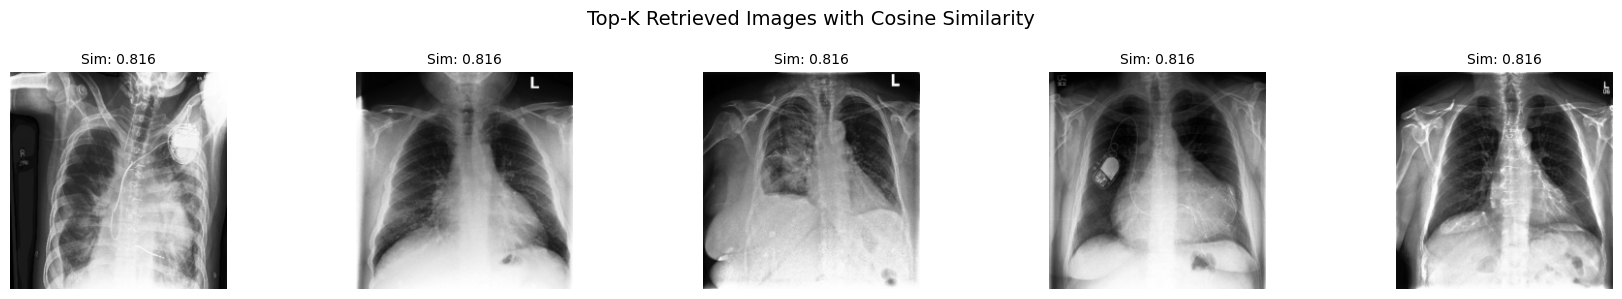

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path

def visualize_top_k_images_with_scores(query_labels, image_df, k=5, image_root=IMAGE_ROOT):
    image_root = Path(image_root)
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]

    fig, axs = plt.subplots(1, k, figsize=(3.5 * k, 3))
    fig.suptitle("Top-K Retrieved Images with Cosine Similarity", fontsize=14)

    for i, idx in enumerate(top_k_indices):
        row = image_df.iloc[idx]
        full_path = image_root / row["filename"]

        image = Image.open(full_path).convert("RGB")
        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title(f"Sim: {sims[idx]:.3f}", fontsize=10)

    plt.tight_layout()
    plt.show()

def retrieve_top_k_images_with_scores(query_labels, image_df, k=5):
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]

    results = image_df.iloc[top_k_indices].copy()
    results["cosine_score"] = sims[top_k_indices]
    return results[["path_to_image", "cosine_score"] + [f"pred_{lbl}" for lbl in LABELS]]


query = np.array([0, 1, 0, 1] + [0] * 10)  # Cardiomegaly + Edema

# Table view
top_df = retrieve_top_k_images_with_scores(query, df_preds, k=5)
display(top_df)

# Image view
visualize_top_k_images_with_scores(query, df_preds, k=5)

In [ ]:
print(IMAGE_ROOT)

/content/drive/MyDrive/test/images/


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/content/drive/MyDrive/impressions_to_label_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(DEVICE)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import pandas as pd

# Load the CSV with image labels
df_stage1_output = pd.read_csv("/content/drive/MyDrive/impression_to_labels_predictions.csv")

# Define the function to predict labels from impression text
def predict_labels(impression, threshold=0.5):
    inputs = tokenizer(impression, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
    return dict(zip(LABELS, (probs >= threshold).astype(int)))

# Define the label columns from the CSV
label_cols = [col for col in df_stage1_output.columns if col.startswith("pred_")]

# Define function to return top-k matching image paths
def impression_to_images(impression_text, top_k=5):
    labels = predict_labels(impression_text)  # returns {label: 0 or 1}

    # Ensure you extract only the relevant predicted labels
    label_vector = [labels[col.replace("pred_", "")] for col in label_cols]  # match original label names

    # Match rows in df_stage1_output
    matches = df_stage1_output[df_stage1_output[label_cols].eq(label_vector).all(axis=1)]

    return matches["path_to_image"].head(top_k).tolist()

In [ ]:
impression_text = "Mild effusion noted in left base with cardiomegaly."
top_images = impression_to_images(impression_text, top_k=5)
print("Top Images:", top_images)

Top Images: ['train/patient22959/study6/view1_frontal.jpg', 'train/patient20931/study1/view1_frontal.jpg', 'train/patient09530/study16/view1_frontal.jpg', 'train/patient03122/study42/view1_frontal.jpg', 'train/patient29439/study1/view1_frontal.jpg']


In [ ]:
def show_top_images_with_labels_from_impression(impression_text, df, top_k=5):
    top_images = impression_to_images(impression_text, top_k=top_k)

    # Build filename and full path
    df["filename"] = df["path_to_image"].str.replace("/", "_").str.replace(".jpg", ".png")
    df["image_path"] = "/content/drive/MyDrive/train/images/" + df["filename"]

    matched_rows = df[df["path_to_image"].isin(top_images)]

    LABELS = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
        'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other',
        'Pneumonia', 'Pneumothorax', 'Support Devices'
    ]

    num_images = len(matched_rows)
    cols = min(num_images, 5)
    rows = (num_images + cols - 1) // cols

    import matplotlib.pyplot as plt
    from PIL import Image

    plt.figure(figsize=(15, 3 * rows))
    for i, (_, row) in enumerate(matched_rows.iterrows()):
        try:
            img = Image.open(row["image_path"]).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {row['image_path']}")
            continue

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        gt_labels = [label for label in LABELS if row[label] == 1]
        pred_labels = [label for label in LABELS if row[f"{label}.1"] == 1]

        title_text = f"GT: {', '.join(gt_labels)}\nPred: {', '.join(pred_labels)}"
        plt.title(title_text, fontsize=8)

    plt.suptitle(f"Top-{top_k} Retrieved Images\nQuery: {impression_text}", fontsize=12)
    plt.tight_layout()
    plt.show()

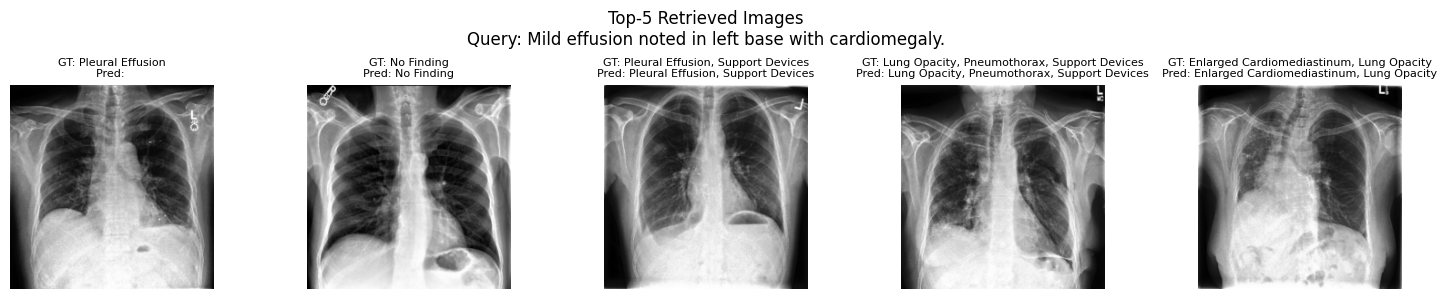

In [ ]:
show_top_images_with_labels_from_impression("Mild effusion noted in left base with cardiomegaly.", df_stage1_output, top_k=5)

In [ ]:
print(predict_labels("Mild effusion noted in left base with cardiomegaly."))

{'Atelectasis': np.int64(0), 'Cardiomegaly': np.int64(1), 'Consolidation': np.int64(0), 'Edema': np.int64(0), 'Enlarged Cardiomediastinum': np.int64(0), 'Fracture': np.int64(0), 'Lung Lesion': np.int64(0), 'Lung Opacity': np.int64(0), 'No Finding': np.int64(0), 'Pleural Effusion': np.int64(1), 'Pleural Other': np.int64(0), 'Pneumonia': np.int64(0), 'Pneumothorax': np.int64(0), 'Support Devices': np.int64(0)}


In [ ]:
print(predict_labels("Bibasilar opacities suggestive of pneumonia. Mild cardiomegaly is present."))

{'Atelectasis': np.int64(0), 'Cardiomegaly': np.int64(0), 'Consolidation': np.int64(0), 'Edema': np.int64(0), 'Enlarged Cardiomediastinum': np.int64(0), 'Fracture': np.int64(0), 'Lung Lesion': np.int64(0), 'Lung Opacity': np.int64(1), 'No Finding': np.int64(0), 'Pleural Effusion': np.int64(0), 'Pleural Other': np.int64(0), 'Pneumonia': np.int64(1), 'Pneumothorax': np.int64(0), 'Support Devices': np.int64(0)}
